In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.colors as mcolors
import scipy
from scipy.ndimage import gaussian_filter1d
import math

In [9]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w'] # An array of colors for matplotlib to access

In [10]:
# % VELOCITY PROFILE GENERATION
velocity_final = 2.5                                                      # Final ball-bot velocity (m/s)
a_start = 2.5                                                          # Start of acceleration (s)
t_final = 20                                                           # Duration of the simulation (s)
t_constant = 5.5 # Ramp lasts from 2.5 s to t_constant                   # Time to reach constant final velocity (s)
dt = 1/200                                                             # Simulation timestep
t_length = int(t_final/dt)                                             # Length of time vector
t = np.linspace(0, t_final, t_length)                                  # Time vector (s)
        
t_ramp_start = int(a_start / dt)
t_ramp_end = round(t_length*(t_constant/t_final))
ramp = np.linspace(0,velocity_final, (t_ramp_end - t_ramp_start) ) 
velocity = np.concatenate((np.zeros(t_ramp_start), ramp, velocity_final*np.ones(t_length - t_ramp_end)))                      # Velocity vector (m/s)
smoothed_velocity = gaussian_filter1d(velocity,100)  #Smoothing velocity with a sigma of 100
linear_acceleration = np.gradient(smoothed_velocity, dt)

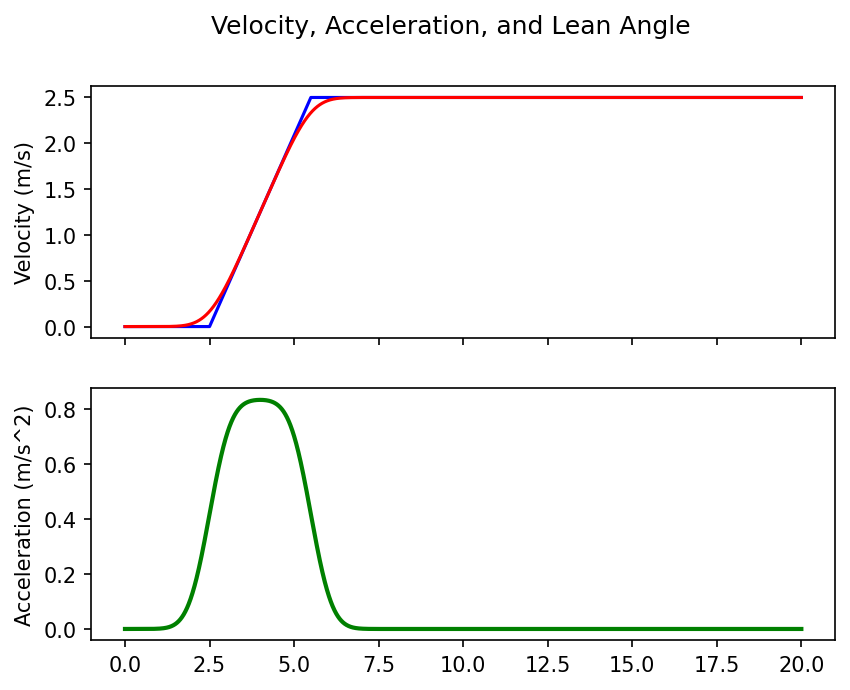

In [12]:
# plt.figure(1)
# plt.figure(dpi=300)
# plt.xlabel('Time (s)')
fig, (vel_plot,accel_plot) = plt.subplots(2,1, sharex=True)
fig.suptitle('Velocity, Acceleration, and Lean Angle')

vel_plot.plot(t,velocity, colors[0])
vel_plot.plot(t,smoothed_velocity,colors[2])
vel_plot.set_ylabel('Velocity (m/s)')

accel_plot.plot(t,linear_acceleration,colors[1], linewidth=2.0)
accel_plot.set_ylabel('Acceleration (m/s^2)')


# lean_plot.plot(t, theta, linewidth=2.0)
# lean_plot.set_ylabel('Lean Angle (rads)')
fig.set_dpi(150)

In [15]:
RHO_STEEL = 7750
RHO_VECTR = 14
RHO_AL = 2700

## approximating telescoping rods as hollow cylinders
s_bar = 4*0.03
l_bar = 1.23
mass_bar = 0.002 * s_bar * l_bar * RHO_STEEL
radius_bar = s_bar / (2 * np.pi)
I_bar = mass_bar * radius_bar**2

## approximating center 'cylinder' as a rectangle (it is actually mostly rectangular)
h_cyl = .1
b_cyl = .15
h_cyl_in = .14
b_cyl_in = .8
l_cyl = 1.23
mass_cyl = l_cyl*(h_cyl * b_cyl - h_cyl_in * b_cyl_in) * RHO_VECTR
I_cyl = 1/12 * mass_cyl*((h_cyl**2 + b_cyl**2) - (h_cyl_in**2 + b_cyl_in**2))

## approximating wheel hub as cylinder closed at one face
radius_hub = .2
mass_hub_base = np.pi * .01 * radius_hub**2 * RHO_STEEL
mass_hub_wall = 2 * np.pi * radius_hub * .01 * RHO_STEEL * .1
I_hub = mass_hub_base / 2 * radius_hub**2 + mass_hub_wall * radius_hub**2

## approximating wheel base as cylinder closed at one base
radius_plate = .25
mass_plate_base = np.pi * .002* radius_plate**2 * RHO_AL
mass_plate_wall = 2 * np.pi * radius_plate * .005 * RHO_AL *.11
I_plate = mass_plate_base / 2 * radius_plate**2 + mass_plate_wall * radius_plate**2

## approximating payload as thin rod about axis
mass_payload = 0
l_payload = 0
I_payload = 1/3 * mass_payload * l_payload**2

## approximating the wheels as a disk
radius_wheel = .75
mass_wheel = .002 * 4.935 * RHO_VECTR #number is calculated SA of torus
I_wheel = 1/2 * mass_wheel * radius_wheel**2
print("Real wheel moment: ", I_wheel)

I_wheel = 2 * I_hub + 2 * I_plate + 2*I_wheel
I_telescope = I_cyl + mass_cyl * .06**2 + 2 * (mass_bar *(.06**2 + .13**2)) + I_payload + mass_payload*.11**2
M_telescope = mass_payload + mass_cyl + 2 * mass_bar
M_w = 2 * (mass_hub_base + mass_hub_wall + mass_wheel + mass_plate_base + mass_plate_wall)
print(f'\tI_wheel:        {I_wheel}\n\
        I_telescope:    {I_telescope}\n\
        Mw:             {M_w}\n\
        M_telescope     {M_telescope}\n')


Real wheel moment:  0.03886312499999999
	I_wheel:        1.604245755333366
        I_telescope:    0.17507576050000004
        Mw:             46.017949036267396
        M_telescope     2.90526



In [16]:
# System Constants
#Materials

safety_factor = 2.5

rho_vectran = 14
rho_steel = 7750
rho_aluminum = 2700

wheel_radius = .75 #Meters
wheel_mass = M_w * safety_factor
wheel_moment = I_wheel * safety_factor

telescope_mass = M_telescope * safety_factor
telescope_moment = I_telescope * safety_factor

total_mass = wheel_mass + telescope_mass

print(f'System Mass: {total_mass}')

System Mass: 122.30802259066849


Text(0, 0.5, 'Angular Acceleration rad/s^2')

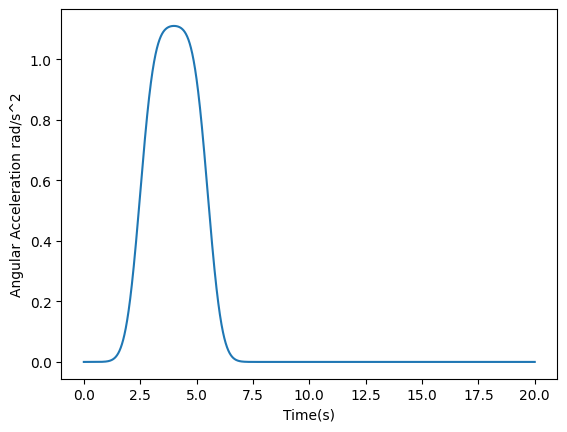

In [17]:
# Converting to angular
angular_velocity = velocity / wheel_radius
angular_acceleration = linear_acceleration / wheel_radius

angular_position = scipy.integrate.cumtrapz(angular_velocity, t)
angular_position = np.append(angular_position, angular_position[t_length-2])

plt.plot(t,angular_acceleration)
plt.xlabel('Time(s)')
plt.ylabel('Angular Acceleration rad/s^2')


In [19]:
# CONTACT FORCE
# contact_force = total_mass * ( scipy.constants.g * np.sin(theta) ) - telescope_moment * theta_ddot

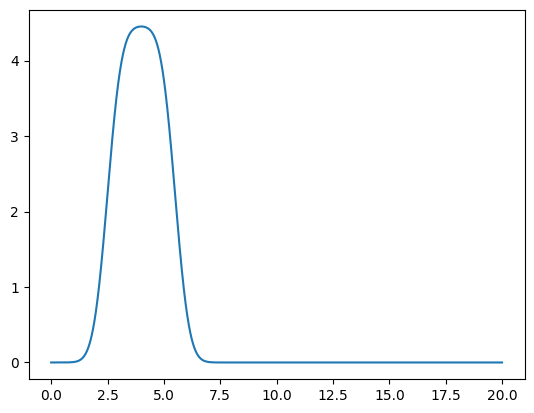

In [20]:
# Wheel Torque Requirement
# T_x = I_w * psi_ddot + F_w_2 * r_w;                                     % Total wheel torque (Nm)

wheel_torque = (wheel_moment * angular_acceleration)
plt.plot(t,wheel_torque)

Text(0, 0.5, 'Angular Velocity (rad/s)')

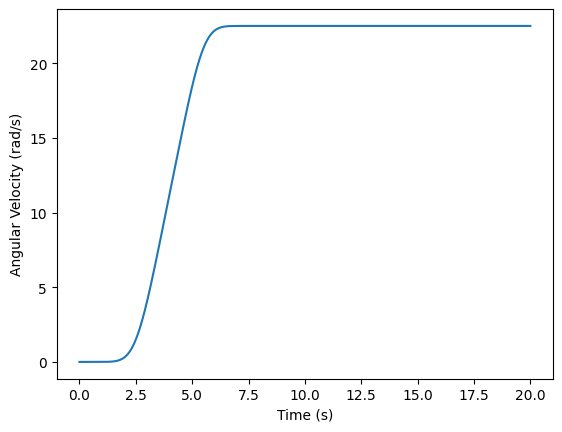

In [21]:
# Transmission Conversion
# Transmission Parameters
ratio = 9
efficiency = .8

motor_velocity = smoothed_velocity * ratio
motor_torque = wheel_torque / ( efficiency * ratio)

plt.plot(t,motor_velocity)
plt.xlabel('Time (s)')
plt.ylabel('Angular Velocity (rad/s)')

Text(0, 0.5, 'Torque (Nm)')

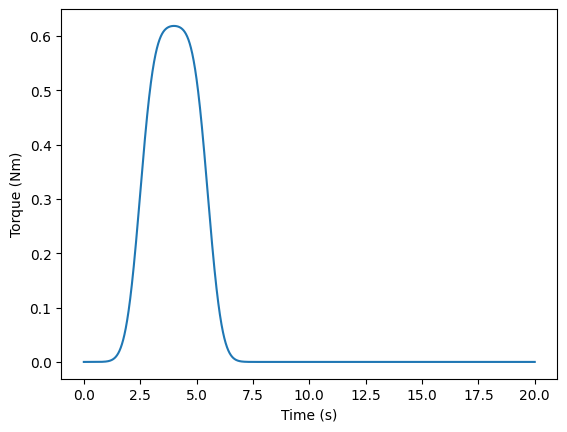

In [22]:
plt.plot(t,motor_torque)
plt.xlabel('Time (s)')
plt.ylabel('Torque (Nm)')

In [25]:
# # Plotting Chassis Lean Angle
# # % LEAN ANGLE - Some contraints on this variable to make the simulation realistic.  

# # Scaling factor for calcuation of lean angle
# import scipy.integrate


# theta_scale = .25
# # Body lean angle (rad)
# theta_ddot = ( motor_torque / telescope_moment )
# theta_dot = scipy.integrate.cumtrapz(theta_ddot, t)
# theta_dot = np.append(theta_dot, theta_dot[t_length - 2])
# print(np.shape(theta_dot))
# print(np.shape(t))

# theta = scipy.integrate.cumtrapz(theta_dot, t)
# theta = np.append(theta, theta[t_length - 2])
# # theta = scipy.integrate.cumtrapz(theta_dot, t)

# # theta_dot = scipy.integrate.cumtrapz(angular_velocity, t)
# # theta_dot = np.append(angular_position, theta_dot[t_length-2])


# # lean_plot.plot(t, theta, linewidth=2.0)
# # lean_plot.set_ylabel('Lean Angle (rads)')
# plt.plot(t,theta_ddot)
# plt.plot(t, theta_dot)
# plt.plot(t,theta)


In [26]:
# Motor Specifications
# Winding: Delta
Kt = .105
R_ll = 170e-3
L = 57e-6 # Warning: given in phase reference frame, unsure how to convert to Le, treating as line to line
J = 607 * (1/1000) * (1 / 100 ** 2)
b =  .16 # Estimate

# Reference Frame Conversions ; All Conversions are for Delta wound
R_phi = (3/2) * R_ll
L_e = (1/2) * L 
Kt_phi_bar = Kt ## QUESTION: IS THIS THE SAME ##
Kt_q = math.sqrt(3/2) * Kt_phi_bar
Kb_q = Kt_q


#Back EMF Calculation
sin_constant = np.pi/180
phase_offsets = np.array([0,  - (2 * math.pi / 3), + (2 * math.pi / 3)]).reshape(3,1)
Kb_phi_a = -Kt_phi_bar * np.sin(angular_position * sin_constant)
Kb_phi_b = -Kt_phi_bar * np.sin(angular_position * sin_constant)
Kb_phi_c = -Kt_phi_bar * np.sin(angular_position  * sin_constant)
backEMF = Kb_phi_a * angular_velocity + Kb_phi_b * angular_velocity + Kb_phi_c * angular_velocity

# q-axis Current
t_q = J * angular_acceleration + b * angular_velocity + motor_torque
I_q = t_q / Kt_q

# Power Loss (Heat Flux)
power_loss = I_q * I_q * R_phi

# q-axis Voltage
I_q_dot = np.gradient(I_q, dt)
V_q = R_phi * I_q + Kb_q * angular_velocity + L_e * I_q_dot

# q-axis to line / terminal (Delta conversions)
I_l_bar = np.sqrt(2) * I_q
V_ll_bar = np.sqrt(2/3) * V_q

Text(0, 0.5, 'Power Loss (Watts)')

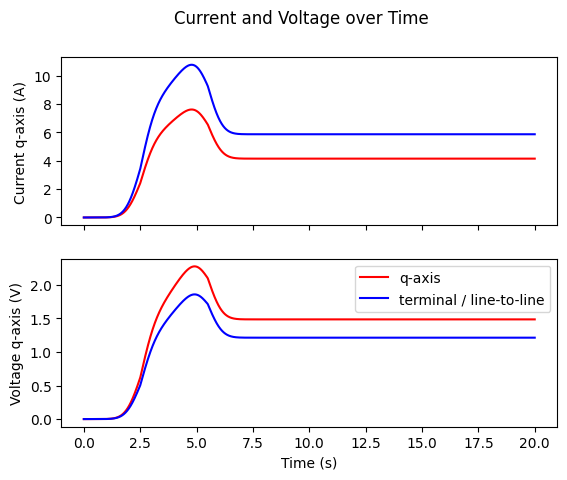

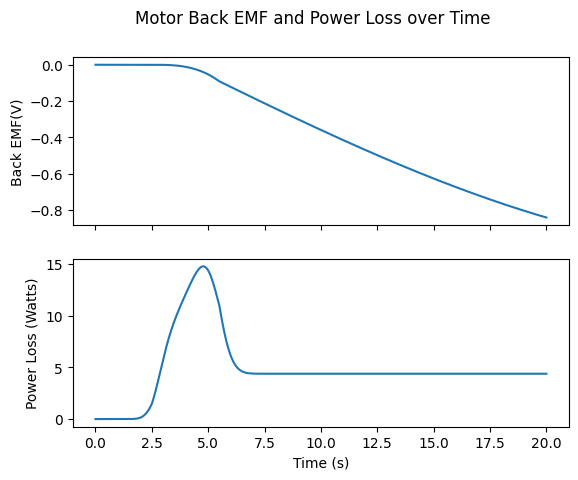

In [27]:
# Graphing Current and Voltage
fig, (I_plot, V_plot) = plt.subplots(2, 1, sharex = True)
fig.suptitle("Current and Voltage over Time")

I_plot.plot(t,I_q, 'r')
I_plot.plot(t,I_l_bar, 'b')
I_plot.set_ylabel('Current q-axis (A)')


V_plot.plot(t, V_q, 'r')
V_plot.plot(t, V_ll_bar, 'b')
V_plot.set_xlabel('Time (s)')
V_plot.set_ylabel('Voltage q-axis (V)')

V_plot.legend(["q-axis", 'terminal / line-to-line'])
# Graphing backEmf and Power
fig, (emf_plot, power_plot) = plt.subplots(2,1, sharex=True)
fig.suptitle("Motor Back EMF and Power Loss over Time")


emf_plot.plot(t, backEMF)
emf_plot.set_ylabel('Back EMF(V)')

power_plot.plot(t, power_loss)
power_plot.set_xlabel('Time (s)')
power_plot.set_ylabel('Power Loss (Watts)')